In [1]:
import sys, os
from models import FCN_model
from preprocessing import ConstantLengthDataGenerator
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import mlflow
from preprocessing.utils import plot
import tensorflow as tf
mlflow.set_experiment("FCN")
mlflow.tensorflow.autolog()

In [2]:
data_path = "./data"
X, y = np.load(f"{data_path}/X.npy", allow_pickle=True), np.load(f"{data_path}/y.npy")
y.shape, X.shape

((60555, 1), (60555,))

In [3]:
mask = np.char.startswith(y, "GunPoint").reshape(-1)
y = y[mask, :]
X = X[mask]
mlflow.log_param("y.unique", np.unique(y))

array(['GunPointAgeSpan_1', 'GunPointAgeSpan_2',
       'GunPointMaleVersusFemale_1', 'GunPointMaleVersusFemale_2',
       'GunPointOldVersusYoung_1', 'GunPointOldVersusYoung_2',
       'GunPoint_1', 'GunPoint_2'], dtype='<U42')

In [4]:
y_encoder = sklearn.preprocessing.OneHotEncoder(categories="auto")
y = y_encoder.fit_transform(y.reshape(-1, 1)).toarray()
mlflow.log_param("y.shape", y.shape)
y.shape, X.shape

((456, 8), (456,))

In [5]:
number_of_classes = y.shape[1]
initial_learning_rate = 1e-4
output_directory = f"{data_path}/models/fcn/outputs"
batch_size = 32
os.makedirs(output_directory, exist_ok=True)

In [6]:
input_layer = keras.layers.Input(shape=(None, 1))
fcn_model = FCN_model(number_of_classes=number_of_classes)(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=fcn_model)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=3, decay_rate=1
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_schedule),
    metrics=["accuracy"],
)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         1536      
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         164096    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                             

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [9]:
kwargs = {"min_length": 256, "max_length": 256, "logging_call": mlflow.log_params}
data_generator_train = ConstantLengthDataGenerator(
    X_train, y_train, batch_size=batch_size, **kwargs
)
data_generator_val = ConstantLengthDataGenerator(
    X_val, y_val, batch_size=len(y_val), **kwargs
)
validation_data = next(data_generator_val)

In [10]:
history = model.fit(data_generator_train, epochs=60, validation_data=validation_data
)

Epoch 1/60
100/100 [==============================] - 22s 205ms/step - loss: 1.9609 - accuracy: 0.2281 - val_loss: 2.0807 - val_accuracy: 0.1140
Epoch 2/60
100/100 [==============================] - 18s 178ms/step - loss: 1.8935 - accuracy: 0.2825 - val_loss: 2.1002 - val_accuracy: 0.1842
Epoch 3/60
100/100 [==============================] - 17s 173ms/step - loss: 1.8343 - accuracy: 0.3022 - val_loss: 2.1565 - val_accuracy: 0.1754
Epoch 4/60
100/100 [==============================] - 18s 179ms/step - loss: 1.8061 - accuracy: 0.3038 - val_loss: 2.1199 - val_accuracy: 0.1754
Epoch 5/60
100/100 [==============================] - 19s 191ms/step - loss: 1.7924 - accuracy: 0.3091 - val_loss: 2.0354 - val_accuracy: 0.2281
Epoch 6/60
100/100 [==============================] - 20s 202ms/step - loss: 1.7566 - accuracy: 0.3225 - val_loss: 1.9466 - val_accuracy: 0.2632
Epoch 7/60
100/100 [==============================] - 18s 180ms/step - loss: 1.7107 - accuracy: 0.3587 - val_loss: 1.8684 - val_ac

100/100 [==============================] - 20s 200ms/step - loss: 1.4508 - accuracy: 0.4000 - val_loss: 1.7789 - val_accuracy: 0.2807
Epoch 58/60
100/100 [==============================] - 20s 204ms/step - loss: 1.4554 - accuracy: 0.4025 - val_loss: 1.9190 - val_accuracy: 0.2544
Epoch 59/60
100/100 [==============================] - 20s 201ms/step - loss: 1.4644 - accuracy: 0.3828 - val_loss: 1.7279 - val_accuracy: 0.2895
Epoch 60/60
1/1 [==============================] - 0s 324ms/step


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmpf9diz5vb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmpf9diz5vb\model\data\model\assets
2023/01/23 10:50:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pacyn\miniconda3\envs\uni\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


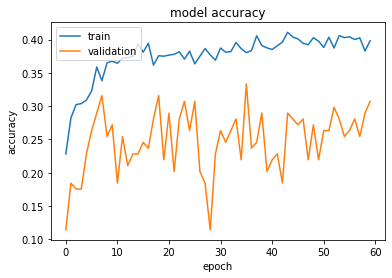

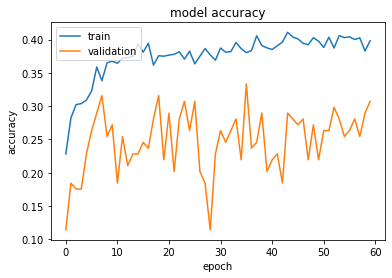

In [11]:
figure = plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [12]:
mlflow.log_figure(figure, "data/figures/acc.png")

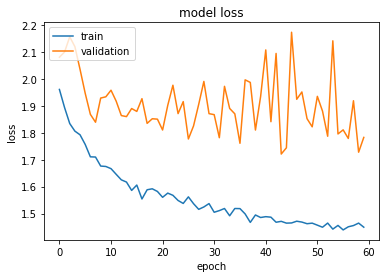

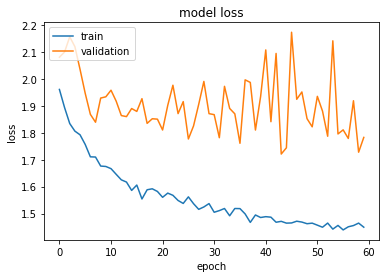

In [13]:
figure = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [14]:
mlflow.log_figure(figure, "data/figures/loss.png")

In [15]:
mlflow.log_artifact("models")
mlflow.log_artifact("preprocessing")

In [16]:
mlflow.end_run()